In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
import folium
import time
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
# import modules
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# load network from pickle
model_date = '202204' #"['202204', '202208']"
location = 'stavanger'
DP_tol = 10
min_samples = 16
data_size = 'full'

model_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+data_size+'_UTM'
model_path = '../../models/networks/best_networks/' + model_name + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_stavanger_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 16,
 'clustering_min_cluster_size': 16,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [4]:
# Load test data from file
path_dates = ['202204', '202205']
crs = network.crs
for i in range(0, len(path_dates)):
    path_date = path_dates[i]
    # load path data from file
    filename = model_name+'_'+path_date+'_paths.csv'
    path_data = pd.read_csv('../../data/paths/'+filename)
    path_data = path_data[path_data.message=='success']
    #path_data = path_data.iloc[0:20]
    
    # Load respective trajectories for evaluation
    traj_file = path_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
    filename = '../../data/processed/' + traj_file + '.parquet'
    traj_gdf = gpd.read_parquet(filename)
    traj_gdf.to_crs(crs, inplace=True)  # Transformation

    if i==0:
        all_path_data = path_data
        all_traj_gdf = traj_gdf
    else:
        all_path_data = pd.concat([all_path_data, path_data])
        all_traj_gdf = pd.concat([all_traj_gdf, traj_gdf])

all_path_data['path'] = all_path_data['path'].apply(literal_eval)
all_path_data = gpd.GeoDataFrame(all_path_data, geometry=gpd.GeoSeries.from_wkt(all_path_data['geometry']), crs=crs)
trajectories = mpd.TrajectoryCollection(all_traj_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

In [5]:
# refine the network on the specified path data
network.refine_graph_from_paths(all_path_data[['mmsi', 'path']], trajectories)

Refining graph based on 26359 passages...
Computing speeds and cross track distances for each trajectory:
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!
Pruning edges and computing edge features...
------------------------
Refined Graph:
Number of nodes: 2241 / 2241 (20 / 19 isolated)
Number of edges: 10101 / 12781
------------------------
Time elapsed: 870.62 minutes


In [6]:
# save hyperparameters
params = network.hyperparameters
params['refinement'] = True
params['refinement_months'] = path_dates
params['refinement_n_paths'] = len(all_path_data)
network.set_hyperparameters(params)

In [7]:
# save network as pickle object
fileObj = open('../../models/networks/refined_networks/'+model_name+'_refined.obj', 'wb')
pickle.dump(network, fileObj)
fileObj.close()

In [8]:
# optional plotting
plotting = True
if plotting:
    map = network.map_graph(refined=True, line_weight=2, min_passages=100)  #tromso: center=[69, 19], oslo: center=[59, 10.5]
    
    # add some trajectories
    all_trajectories = network.trajectories
    selection_start = 0
    selection_end = 1 #len(all_trajectories)
    selection_step = 1
    selection = np.arange(selection_start, selection_end, selection_step)
    #selection = [0, 1, 10, 100, 500, 1000, 2999, 5000]
    mmsis = path_data.mmsi.iloc[selection]
    #mmsis=['258725000_27_2022-05-06 01:36:06']
    for mmsi in mmsis:
        print(mmsi)
        trajectory = trajectories.get_trajectory(mmsi)
        path_df_sspd, evaluation_results_sspd = network.trajectory_to_path_sspd(trajectory, verbose=False)
        print(evaluation_results_sspd[['message', 'SSPD']])
        print('------------------')
        try:
            map = trajectory.to_line_gdf()[['geometry', 'mmsi', 'skipsgruppe']].explore(m=map, style_kwds={'weight':3, 'color':'black', 'opacity':1}, 
                                                                          name=mmsi+' trajectory')
            map = path_df_sspd.explore(m=map, name=mmsi+' edge_sequence sspd', style_kwds={'weight':3, 'color':'cyan', 'opacity':1})
        except:
            print(mmsi+': no path found')
    
    folium.LayerControl().add_to(map)
    map

205655000_0_2022-05-07 21:22:02
   message        SSPD
0  success  267.439233
------------------



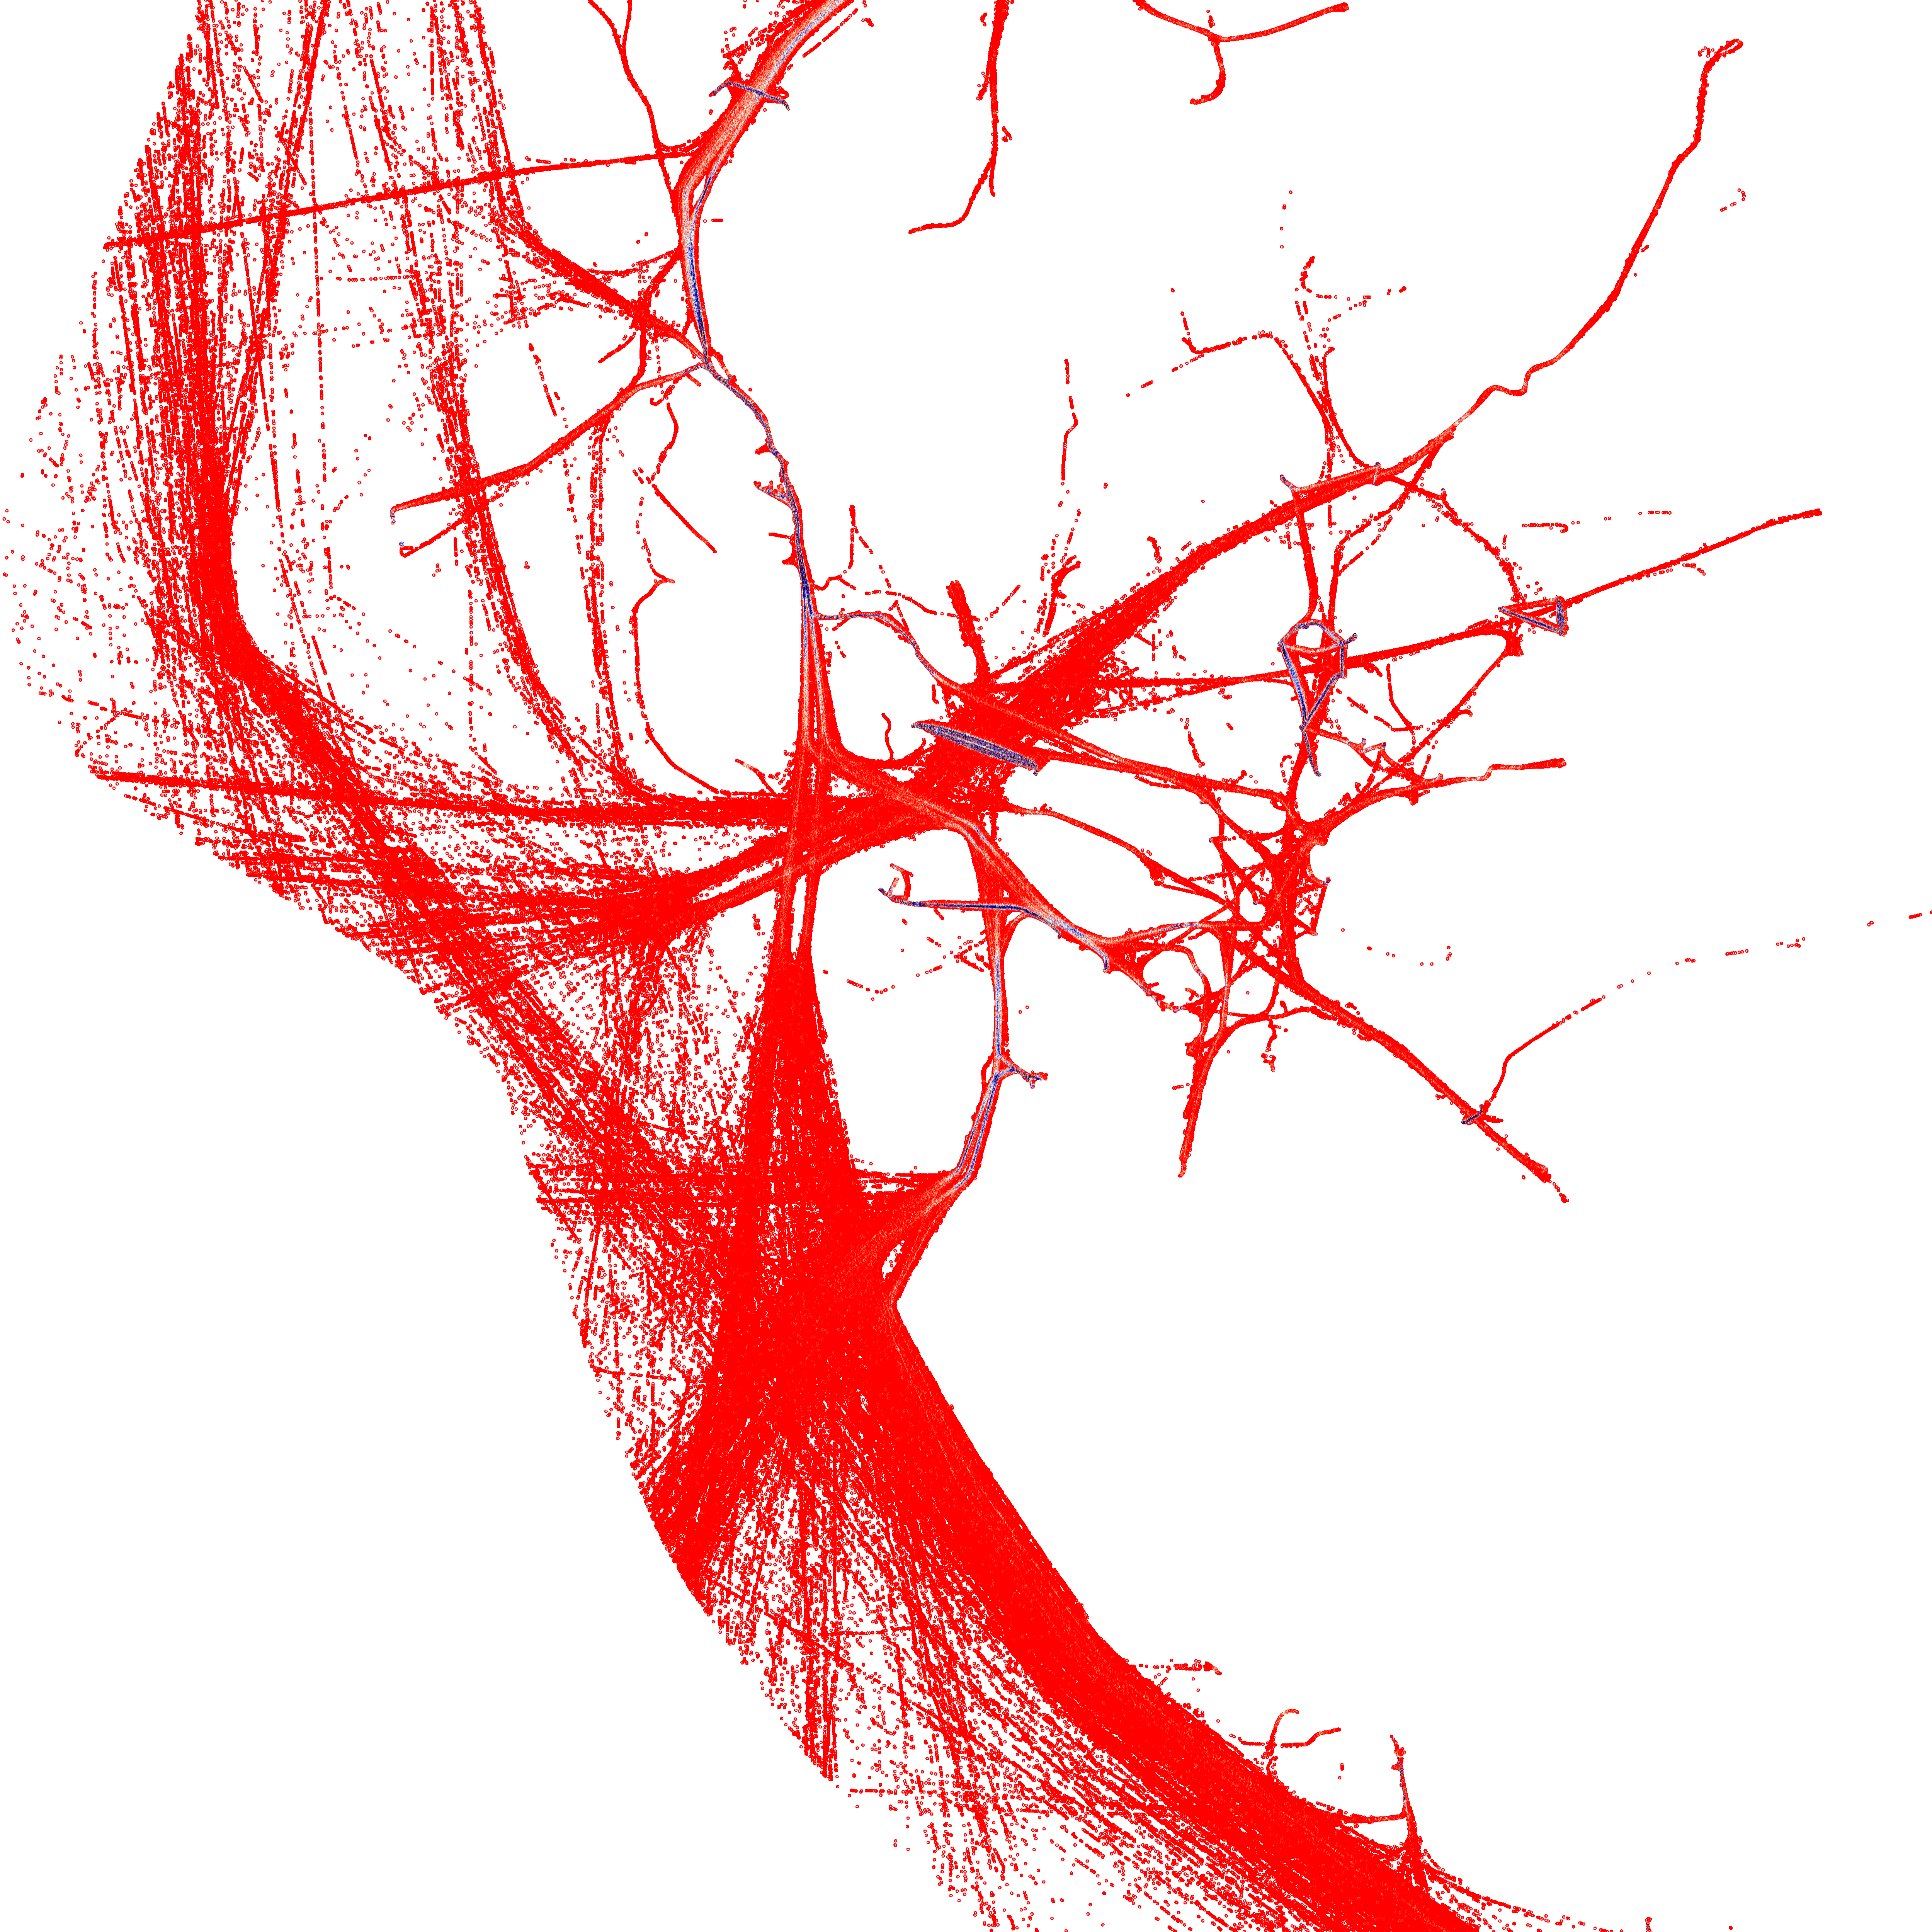

In [9]:
map

In [10]:
path = all_path_data.path.iloc[0]

In [11]:
mmsis = []
for i in range(0, len(all_path_data)):
    path = all_path_data.path.iloc[i]
    bad_edge = [577, 244]
    if bad_edge in [path[i:len(bad_edge)+i] for i in range(len(path))]:
        print(all_path_data.mmsi.iloc[i])

In [12]:
a = [2,4,3,5,7] 
b = [3,7]
b in [a[i:len(b)+i] for i in range(len(a))]

False